In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

### Clean Bridge data again

In [2]:
df = pd.read_excel("BMMS_overview.xlsx")
df_b = df[df["road"] == "N1"][:]
dup = (df_b.sort_values("km").duplicated("km", keep = "first")
       |
       df_b.sort_values("km").duplicated("km", keep = "last"))
df_b.loc[dup].sort_values("km")

new_df = pd.DataFrame()
for i in range(len(df_b.loc[dup]["km"].unique())):
    df_ele = df_b.loc[dup][df_b.loc[dup]["km"] == df_b.loc[dup]["km"].unique()[i]]
    df_ele.fillna(method = "ffill", inplace = True)
    df_ele.fillna(method = "bfill", inplace = True)

    new_df = pd.concat([new_df, df_ele])
df_b.loc[new_df.index] = new_df
df_b = df_b.drop_duplicates("km", keep = "last").sort_values("km")
df_b = df_b.reset_index()
df_b.to_csv("cleaned_bridge.csv")

# Geopandas visualization

# 1. Preparation

In [3]:
import geopandas as gpd
import os

In [4]:
geodata = gpd.read_file('C:\\Users\\yubin\\OneDrive\\EPA1351_Advanced_Discrete_Simulation\\3. Lab3\\Python Script'
                        + "\\bgd_shape\\BGD_bnda_adm2_2015.shp")

## 1) Load disaster data (tornado, flood, earthquake, cyclone)

In [5]:
df_disaster = pd.read_csv("Regional_disaster.csv")
df_disaster.head()

,region,tornado_Fr,flood_Fr,earthquake_Fr,cyclone_Fr,flood_Class,earthquake_Class,cyclone_Class
0,Bagerhat,2,3,3,6,Non-flooding,Zone1,High-risk
1,Bandaban,0,2,8,0,Severe,Zone3,High-wind
2,Barguna,0,2,3,1,Non-flooding,Zone1,High-risk
3,Barishal,3,6,3,21,Severe,Zone1,High-risk
4,Bhola,2,4,3,5,Moderate,Zone1,High-risk


In [6]:
# some name of regions are not consistent (i.e. pabna and pabana)

In [7]:
df_disaster["region"].unique()[48]

'Pabana'

In [8]:
geodata["adm2_en"].unique()[45]

'Pabna'

## 2) Syncronize the name of the region

In [9]:
# trim and lower case
df_disaster["region"] = df_disaster["region"].apply(lambda x: x.strip().lower())
geodata["adm2_en"] = geodata["adm2_en"].apply(lambda x: x.strip().lower())

In [10]:
def word_to_dict(word):
    """
    make the histogram of the letter's frequency in the word
    """
    d = {}
    for letter in word:
        if letter not in d:
            d[letter] = 1
        else:
            d[letter] += 1
    return d

def similarity(s1, s2):
    """
    calculate similarity
    """
    d1 = word_to_dict(s1)
    d2 = word_to_dict(s2)
    
    count = 0
    for c in d1.keys():
        if c in d2.keys():
            count += 1
    return np.mean([count/len(d1), count/len(d2)])

def mapping_dict(df_disaster, geodata):    
    """
    return the dictionary which maps inconsistent name
    """
    ls1 = []
    for region in df_disaster["region"].values:
        if region not in geodata["adm2_en"].values:
            ls1.append(region)

    ls2 = []
    for adm2 in geodata["adm2_en"].values:
        if adm2 not in df_disaster["region"].values:
            ls2.append(adm2)
    ls_total = []
    for l1 in ls1:
        ls_sub = []
        for l2 in ls2:
            ls_sub.append(similarity(l1, l2))
        ls_sub = np.array(ls_sub)
        ls_total.append(ls_sub.argmax())
        
    return dict(zip(ls1, np.array(ls2)[ls_total]))

# create the dictionary
map_d = mapping_dict(df_disaster, geodata)

# replace the value by the dictionary
df_disaster.replace({"region":map_d}, inplace = True)

In [11]:
# check whether they are now consistent
region = df_disaster["region"].unique()
region.sort()
adm2 = geodata["adm2_en"].unique()
adm2.sort()

region == adm2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [12]:
# All names are now consistent
print(df_disaster["region"].unique()[48])
print(geodata["adm2_en"].unique()[45])

pabna
pabna


## 3) Join two data sets (Geopanda + Disaster)

In [13]:
df_final = pd.merge(geodata, df_disaster, left_on = "adm2_en", right_on = "region")
df_final.head()

,A1remark,A2remark,adm2_en,adm1_en,adm0_en,a2code,a2code_old,a1code,a1code_old,a0code,geometry,region,tornado_Fr,flood_Fr,earthquake_Fr,cyclone_Fr,flood_Class,earthquake_Class,cyclone_Class
0,None,None,bagerhat,Khulna,Bangladesh,4001,4001,40,40,BD,(POLYGON ((89.84021305089163 21.82784321978876...,bagerhat,2,3,3,6,Non-flooding,Zone1,High-risk
1,None,None,bandarban,Chittagong,Bangladesh,2003,2003,20,20,BD,"POLYGON ((92.38064976300009 22.33063843200005,...",bandarban,0,2,8,0,Severe,Zone3,High-wind
2,None,None,barguna,Barisal,Bangladesh,1004,1004,10,10,BD,(POLYGON ((89.87967503337612 22.07868995257926...,barguna,0,2,3,1,Non-flooding,Zone1,High-risk
3,None,None,barisal,Barisal,Bangladesh,1006,1006,10,10,BD,(POLYGON ((90.55428796400004 22.59271435799996...,barisal,3,6,3,21,Severe,Zone1,High-risk
4,None,None,bhola,Barisal,Bangladesh,1009,1009,10,10,BD,(POLYGON ((90.77172486200008 21.85594846899998...,bhola,2,4,3,5,Moderate,Zone1,High-risk


# 2. Plot

## 1) Area of our interest = Where bridges are located

In [14]:
# load bridge
df_b = pd.read_csv("cleaned_bridge.csv", index_col = 0)

In [15]:
# redions of our interest: 4 regions -> 'narayanganj', 'comilla', 'feni', 'chittagong'
region_bridge = df_b["division"].apply(lambda x: x.strip().lower()).unique().tolist()
region_bridge

['narayanganj', 'comilla', 'feni', 'chittagong', 'dohazari', "cox's bazar"]

## 2) Plot the Disaster data

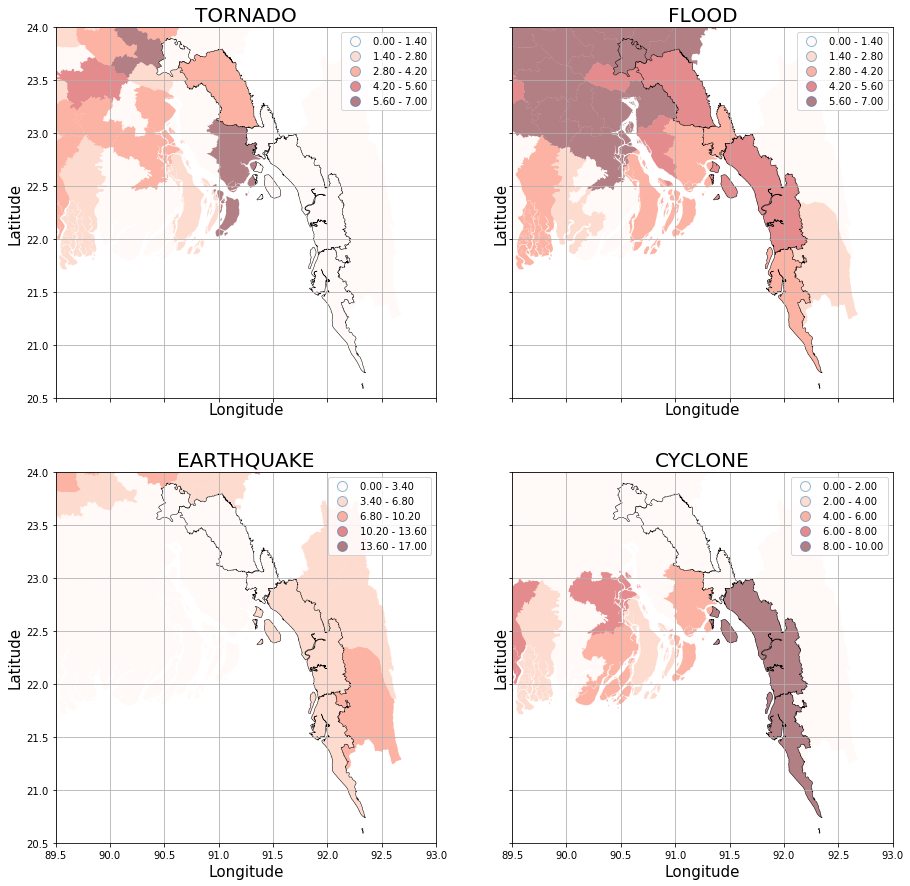

In [16]:
fig, axes = plt.subplots(ncols = 2, nrows = 2,
                         sharex=True, sharey=True,
                         figsize = (15, 15),
                        )

# plot disasters (4 types) occurences
t = (0,0), (0,1), (1,0), (1,1)
dis = df_disaster.columns[1:5].values
for i in range(len(dis)):
    df_final.plot(ax = axes[t[i]],
                  scheme='equal_interval',
                  column = dis[i], k = 5, cmap='Reds', 
                  alpha = 0.5,
                  legend = True,
                  categorical=True
                 )

#     plot the region in our interest
    for region in region_bridge:
        gpd.plotting.plot_polygon_collection(ax = axes[t[i]],
                                             geoms = geodata[geodata["adm2_en"] == region]["geometry"],
                                             facecolor = "none",
                                             edgecolor = "black",
                                             lw = 0.5)

#     set details
    axes[t[i]].set_title(dis[i][:-3].upper(), fontsize = 20)
    axes[t[i]].grid()
    
    axes[t[i]].set_xlabel("Longitude", fontsize = 15)
    axes[t[i]].set_ylabel("Latitude", fontsize = 15)
    
#     Magnify
    axes[t[i]].set_xbound(89.5, 93)
    axes[t[i]].set_ybound(20.5, 24)

## 3) Add Bridges

In [17]:
# convert bridge data into geopandas data frame
from shapely.geometry import Point

df_b_geo = [Point(xy) for xy in zip(df_b.lon, df_b.lat)]
df_b.drop(['lon', 'lat'], axis=1, inplace = True)
crs = {'init': 'epsg:4326'}
gpd_b = gpd.GeoDataFrame(df_b, crs=crs, geometry = df_b_geo)

In [18]:
# convert ABCD into Numeric Value
Cats = gpd_b["condition"].unique()
Cats.sort()

def CategoryToNumeric(Cat):
    for i in range(len(Cats)):
        if Cat == Cats[i]:
            return 3-i

# assign color gradation
gpd_b["cond_num"] = gpd_b["condition"].apply(lambda x: CategoryToNumeric(x))
gpd_b["colors"] = ["#%02x%02x%02x" % (int(r), int(g), int(b))
                  for r, g, b, _ in 255 * mpl.cm.Reds(mpl.colors.Normalize()(gpd_b["cond_num"].values))
                 ]

In [19]:
Colors = ["Darkgreen", "Green", "Orange", "Red"]
gpd_b["colors"] = gpd_b["condition"].map(dict(zip(Cats, Colors)))
dict(zip(Cats, Colors))

{'A': 'Darkgreen', 'B': 'Green', 'C': 'Orange', 'D': 'Red'}

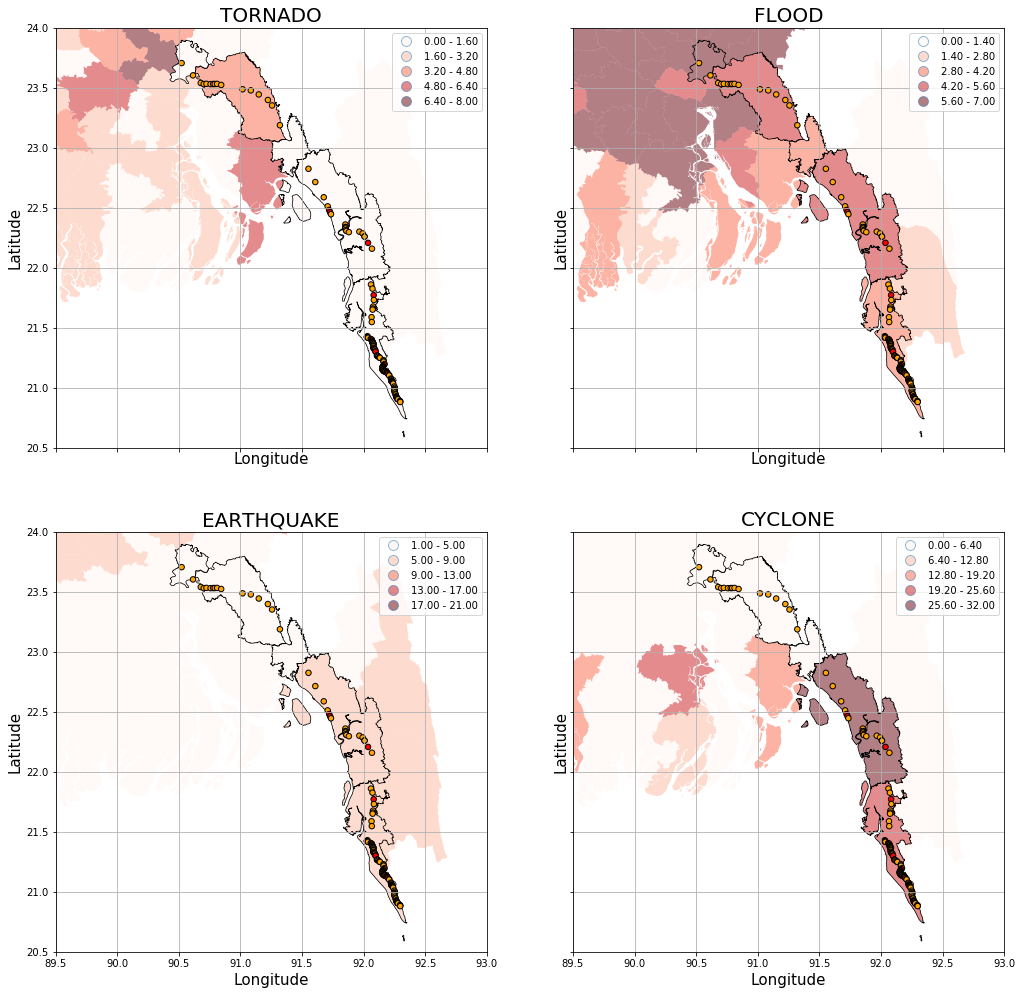

In [20]:
# Add bridge data on the above map
fig, axes = plt.subplots(ncols = 2, nrows = 2,
                         sharex=True, sharey=True,
                         figsize = (17, 17),
                        )

# plot disasters (4 types) occurences
t = (0,0), (0,1), (1,0), (1,1)
dis = df_disaster.columns[1:5].values

# exclude A and B
bridge_cat = gpd_b["condition"].apply(lambda x: (x != "A") & (x != "B"))
for i in range(len(dis)):
    kw = dict(column = dis[i], k = 5, cmap='Reds')
    df_final.plot(ax = axes[t[i]],
                  scheme='equal_interval',
                  **kw, alpha = 0.5,
                  legend = True)

#     plot the region in our interest
    for region in region_bridge:
        gpd.plotting.plot_polygon_collection(ax = axes[t[i]],
                                             geoms = geodata[geodata["adm2_en"] == region]["geometry"],
                                             facecolor = "none",
                                             edgecolor = "black", lw = 0.75)
        
#     plot bridges
    gpd.plotting.plot_point_collection(ax = axes[t[i]],
                                       geoms = gpd_b[bridge_cat]["geometry"],
                                       marker = "o", markersize = 30,
                                       color = gpd_b[bridge_cat]["colors"], edgecolor = "black",
                                      )

#     set details
    axes[t[i]].set_title(dis[i][:-3].upper(), fontsize = 20)
    axes[t[i]].grid()
    
    axes[t[i]].set_xlabel("Longitude", fontsize = 15)
    axes[t[i]].set_ylabel("Latitude", fontsize = 15)
    
#     Magnify
    axes[t[i]].set_xbound(89.5, 93)
    axes[t[i]].set_ybound(20.5, 24)

## 4) Add Traffic Data

In [21]:
# load traffic data
df_tr = pd.read_csv("N1_traffic.csv", index_col = 0)
df_tr.iloc[:,2:].head()

,LRP_Start,Offset_Start,Chainage_Start,LRP_End,Offset_End,Chainage_End,(Km),Heavy Truck,Medium Truck,Small Truck,...,Utility,Car,Auto Rickshaw,Motor Cycle,Bi-Cycle,Cycle Rickshaw,Cart,Motorized,Non Motorized,Total AADT
0,LRPS,0,0.000,LRPS,822,0.822,0.822,1062,11997,2701,...,718,4459,5488,834,445,1977,0,38472,2422,40894
1,LRPS,822,0.822,LRPS,4175,4.175,3.353,1062,11997,2701,...,718,4459,5488,834,445,1977,0,38472,2422,40894
2,LRPS,4175,4.175,LRPS,7181,7.181,3.006,176,5250,4237,...,612,3299,4423,2122,147,2338,0,31733,2485,34218
3,LRPS,7181,7.181,LRP009,260,8.763,1.582,327,5860,2926,...,665,3527,5847,2305,728,2608,0,31997,3336,35333
4,LRP009,260,8.763,LRP012,439,11.936,3.173,327,9384,6699,...,594,3684,6234,2297,728,2608,0,45132,3336,48468


In [22]:
# traffic data
df_tr = df_tr[["Chainage_End", "Total AADT"]]
df_tr.columns.values[0] = "chainage"
df_tr["index"] = np.arange(len(gpd_b), len(gpd_b) + len(df_tr), 1)
df_tr = df_tr.set_index("index")
idx = df_b.index

# concat bridge + traffic
gpd_b = pd.concat([gpd_b, df_tr]).sort_values("chainage")
gpd_b["Total AADT"] = gpd_b["Total AADT"].fillna(method = "bfill")
gpd_b = gpd_b.loc[idx]
gpd_b.iloc[:, :10].head()

,EstimatedLoc,LRPName,Total AADT,chainage,circle,colors,cond_num,condition,constructionYear,division
0,interpolate,LRP001a,40894.0,1.800,Dhaka,Darkgreen,3.0,A,2005.0,Narayanganj
1,interpolate,LRP004b,34218.0,4.925,Dhaka,Darkgreen,3.0,A,2006.0,Narayanganj
2,interpolate,LRP008b,48468.0,8.976,Dhaka,Orange,1.0,C,1986.0,Narayanganj
3,interpolate,LRP010a,48468.0,10.543,Dhaka,Green,2.0,B,1987.0,Narayanganj
4,interpolate,LRP010b,48468.0,10.880,Dhaka,Darkgreen,3.0,A,1992.0,Narayanganj


In [23]:
# Log
gpd_b["log_traffic"] = np.log2(gpd_b["Total AADT"])
gpd_b["log_traffic"].head()

0    15.319602
1    15.062468
2    15.564745
3    15.564745
4    15.564745
Name: log_traffic, dtype: float64

In [24]:
# Normalize
mul = 5000
gpd_b["norm_traffic"] = gpd_b["Total AADT"].apply(lambda x: mul*x/gpd_b["Total AADT"].sum())

In [25]:
# Divide
gpd_b["div_traffic"] = gpd_b["Total AADT"].apply(lambda x: x/1000)

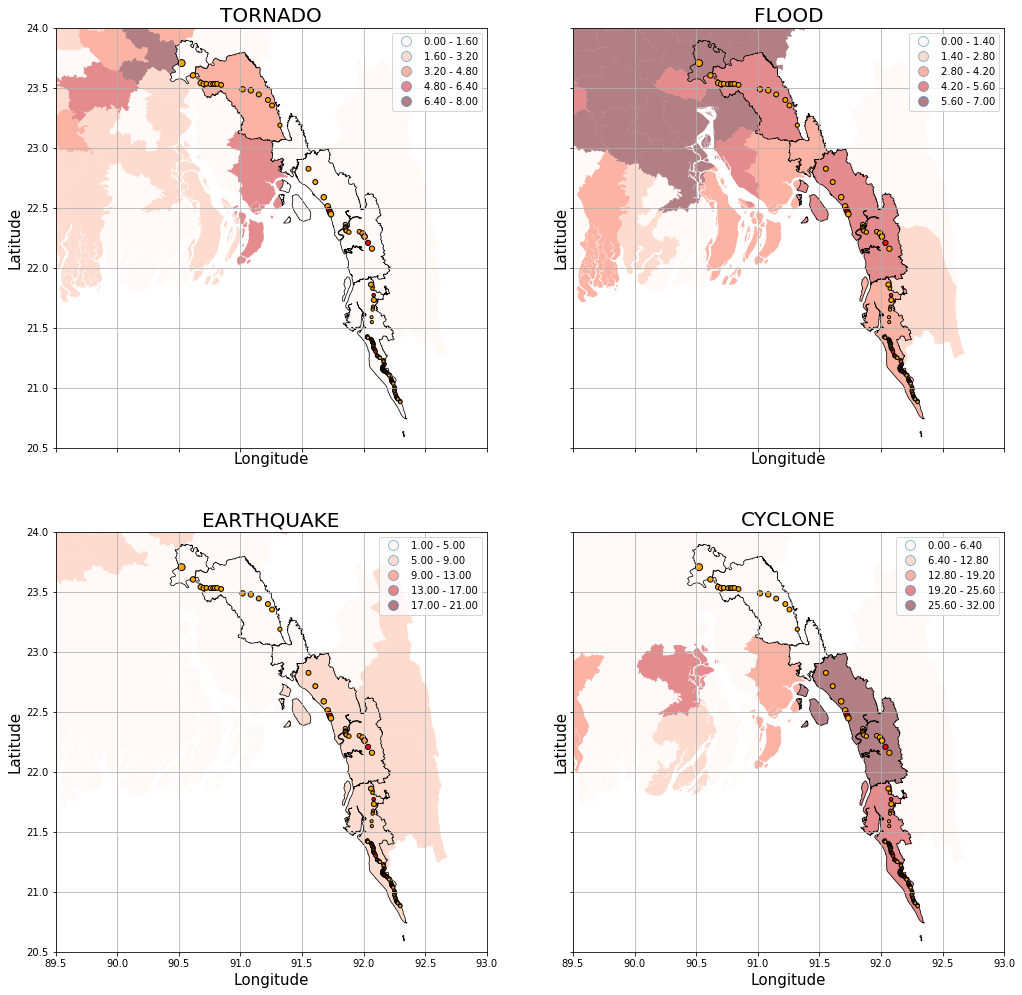

In [26]:
# Add bridge data on the above map
fig, axes = plt.subplots(ncols = 2, nrows = 2,
                         sharex=True, sharey=True,
                         figsize = (17, 17),
                        )

# plot disasters (4 types) occurences
t = (0,0), (0,1), (1,0), (1,1)
dis = df_disaster.columns[1:5].values
bridge_cat = gpd_b["condition"].apply(lambda x: (x != "A") & (x != "B"))
for i in range(len(dis)):
    kw = dict(column = dis[i], k = 5, cmap='Reds')
    df_final.plot(ax = axes[t[i]],
                  scheme='equal_interval',
                  **kw, alpha = 0.5,
                  legend = True)

#     plot the region in our interest
    for region in region_bridge:
        gpd.plotting.plot_polygon_collection(ax = axes[t[i]],
                                             geoms = geodata[geodata["adm2_en"] == region]["geometry"],
                                             facecolor = "none",
                                             edgecolor = "black", lw = 0.75)
        
#     plot bridges
    gpd.plotting.plot_point_collection(ax = axes[t[i]],
                                       geoms = gpd_b[bridge_cat]["geometry"],
                                       marker = "o",
                                       markersize = gpd_b[bridge_cat]["div_traffic"],
                                       color = gpd_b[bridge_cat]["colors"], edgecolor = "black",
                                      )

#     set details
    axes[t[i]].set_title(dis[i][:-3].upper(), fontsize = 20)
    axes[t[i]].grid()
    
    axes[t[i]].set_xlabel("Longitude", fontsize = 15)
    axes[t[i]].set_ylabel("Latitude", fontsize = 15)
    
#     Magnify
    axes[t[i]].set_xbound(89.5, 93)
    axes[t[i]].set_ybound(20.5, 24)

# Add Road data

In [27]:
df = pd.read_csv("_roads3.csv")
df_r = df[df["road"] == "N1"][:]
# df_r = df_r.loc[:564]

df_tr = pd.read_csv("N1_traffic.csv", index_col = 0)
df_tr = df_tr[["Chainage_End", "Total AADT"]]
df_tr.columns.values[0] = "chainage"
df_tr["index"] = np.arange(len(df_r), len(df_r) + len(df_tr), 1)
df_tr = df_tr.set_index("index")
idx = df_r.index

# concat road + traffic
df_r = pd.concat([df_r, df_tr]).sort_values("chainage")
df_r["Total AADT"] = df_r["Total AADT"].fillna(method = "bfill")
df_r = df_r.loc[idx]

In [28]:
# coloring
df_r["traffic"] = df_r["Total AADT"]
df_r.drop("Total AADT", axis = 1, inplace = True)
df_r["norm_traffic"] = df_r["traffic"].apply(lambda x: x/df_r["traffic"].sum())
df_r["log_traffic"] = df_r["traffic"].apply(lambda x: np.log(x))

# colors gradiation
df_r["colors"] = ["#%02x%02x%02x" % (int(r), int(g), int(b))
                  for r, g, b, _ in 255 * mpl.cm.summer(mpl.colors.Normalize()(df_r["traffic"].values))
                 ]

# colors gradiation with logscale
df_r["log_colors"] = ["#%02x%02x%02x" % (int(r), int(g), int(b))
                  for r, g, b, _ in 255 * mpl.cm.summer(mpl.colors.Normalize()(df_r["log_traffic"].values))
                 ]

In [29]:
# transfrom road data into geopandas data frame
from shapely.geometry import LineString

df_r_geo = [Point(xy) for xy in zip(df_r.lon, df_r.lat)]
df_r.drop(['lon', 'lat'], axis=1, inplace = True)
crs = {'init': 'epsg:4326'}
gpd_r = gpd.GeoDataFrame(df_r, crs=crs, geometry = df_r_geo)

In [30]:
for i in range(len(gpd_r)-1):
    gpd_r.loc[i, "geometry"] = LineString([gpd_r.loc[i, "geometry"],
                                           gpd_r.loc[i+1, "geometry"]])

In [31]:
gpd_r = gpd_r[:-1]

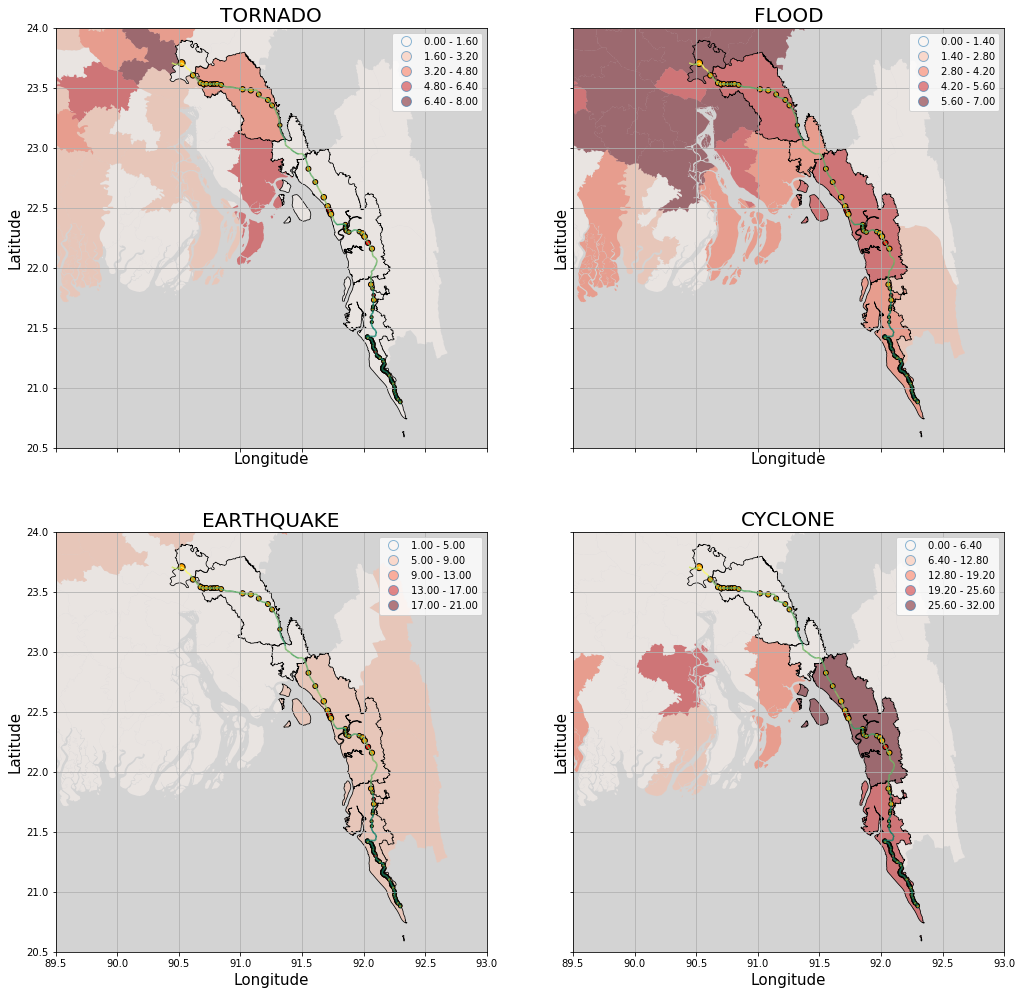

In [32]:
# Add bridge data on the above map
fig, axes = plt.subplots(ncols = 2, nrows = 2,
                         sharex=True, sharey=True,
                         figsize = (17, 17),
                        )

# plot disasters (4 types) occurences
t = (0,0), (0,1), (1,0), (1,1)
dis = df_disaster.columns[1:5].values
bridge_cat = gpd_b["condition"].apply(lambda x: (x != "A") & (x != "B"))
for i in range(len(dis)):
    kw = dict(column = dis[i], k = 5, cmap='Reds')
    df_final.plot(ax = axes[t[i]],
                  scheme='equal_interval',
                  **kw, alpha = 0.5,
                  legend = True)

#     plot the region in our interest
    for region in region_bridge:
        gpd.plotting.plot_polygon_collection(ax = axes[t[i]],
                                             geoms = geodata[geodata["adm2_en"] == region]["geometry"],
                                             facecolor = "none",
                                             edgecolor = "black", lw = 0.75)
    
#     plot road   
    gpd.plotting.plot_linestring_collection(ax = axes[t[i]],
                                            geoms = gpd_r["geometry"],
                                            color = gpd_r["colors"],
                                           )
        
#     plot bridges
    gpd.plotting.plot_point_collection(ax = axes[t[i]],
                                       geoms = gpd_b[bridge_cat]["geometry"],
                                       marker = "o",
                                       markersize = gpd_b[bridge_cat]["div_traffic"],
                                       color = gpd_b[bridge_cat]["colors"], edgecolor = "black",
                                      )

#     set details
    axes[t[i]].set_title(dis[i][:-3].upper(), fontsize = 20)
    axes[t[i]].grid()
    
    axes[t[i]].set_xlabel("Longitude", fontsize = 15)
    axes[t[i]].set_ylabel("Latitude", fontsize = 15)
    
    axes[t[i]].set_facecolor("lightgray")
    
#     Magnify
    axes[t[i]].set_xbound(89.5, 93)
    axes[t[i]].set_ybound(20.5, 24)

## Plot Top 10 (Traffic Volume)

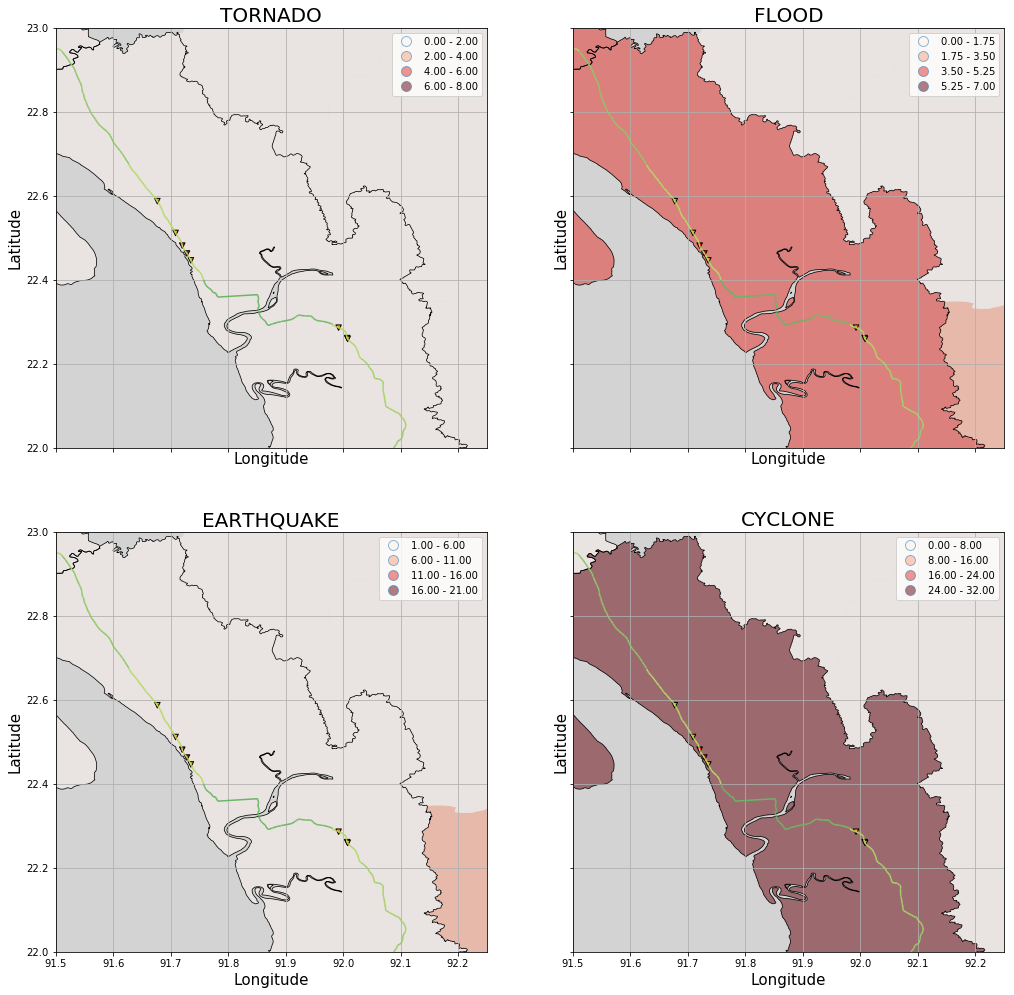

In [33]:
# Add bridge data on the above map
fig, axes = plt.subplots(ncols = 2, nrows = 2,
                         sharex=True, sharey=True,
                         figsize = (17, 17),
                        )

# plot disasters (4 types) occurences
t = (0,0), (0,1), (1,0), (1,1)
dis = df_disaster.columns[1:5].values

# sort out top 10 among C and D
bridge_cat = gpd_b.index[(gpd_b.condition != "A") & (gpd_b.condition != "B")]
bridge_cat = gpd_b.loc[bridge_cat].nlargest(10, "Total AADT").index

for i in range(len(dis)):
    kw = dict(column = dis[i], k = 4, cmap='Reds')
    df_final.plot(ax = axes[t[i]],
                  scheme='equal_interval',
                  **kw, alpha = 0.5,
                  legend = True)

#     plot the region in our interest
    for region in region_bridge:
        gpd.plotting.plot_polygon_collection(ax = axes[t[i]],
                                             geoms = geodata[geodata["adm2_en"] == region]["geometry"],
                                             facecolor = "none",
                                             edgecolor = "black", lw = 0.75)
#     plot road (method 1)
    kw = {"solid_capstyle": "round"}
    gpd_r.plot(ax = axes[t[i]], color = gpd_r["log_colors"])

#     plot bridges (method 2)
    gpd.plotting.plot_point_collection(ax = axes[t[i]],
                                       geoms = gpd_b.loc[bridge_cat]["geometry"],
                                       marker = "v", edgecolor = "black",
                                       markersize = gpd_b.loc[bridge_cat]["div_traffic"],
                                       color = gpd_b.loc[bridge_cat]["colors"],
                                       )
    


#     set details
    axes[t[i]].set_title(dis[i][:-3].upper(), fontsize = 20)
    axes[t[i]].grid()
    
    axes[t[i]].set_xlabel("Longitude", fontsize = 15)
    axes[t[i]].set_ylabel("Latitude", fontsize = 15)
    
    axes[t[i]].set_facecolor("lightgray")
    
#     Magnify
    axes[t[i]].set_xbound(90.25, 92.5)
    axes[t[i]].set_ybound(20.5, 24)
    
    axes[t[i]].set_xbound(91.5, 92.25)
    axes[t[i]].set_ybound(22, 23)
    

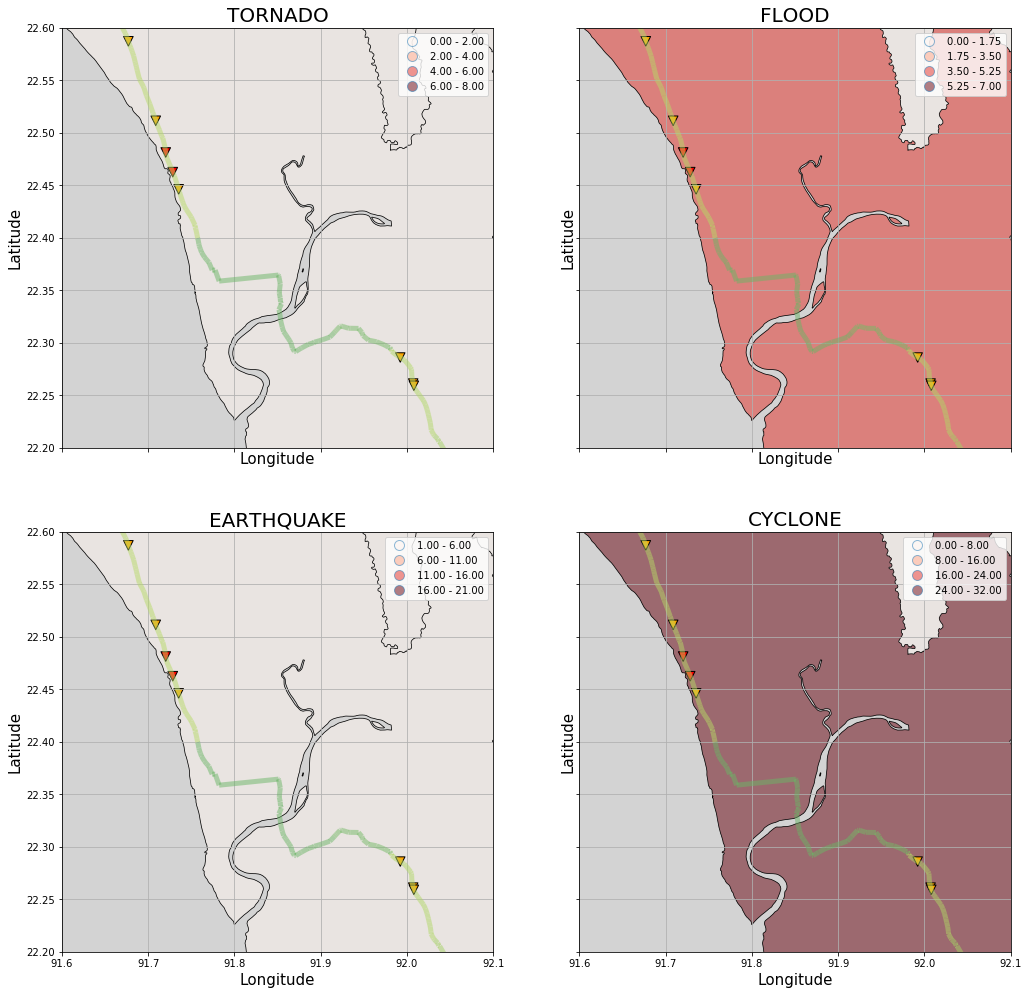

In [34]:
# Add bridge data on the above map
fig, axes = plt.subplots(ncols = 2, nrows = 2,
                         sharex=True, sharey=True,
                         figsize = (17, 17),
                        )

# plot disasters (4 types) occurences
t = (0,0), (0,1), (1,0), (1,1)
dis = df_disaster.columns[1:5].values

# sort out top 10 among C and D
bridge_cat = gpd_b.index[(gpd_b.condition != "A") & (gpd_b.condition != "B")]
bridge_cat = gpd_b.loc[bridge_cat].nlargest(10, "Total AADT").index

for i in range(len(dis)):
    kw = dict(column = dis[i], k = 4, cmap='Reds')
    df_final.plot(ax = axes[t[i]],
                  scheme='equal_interval',
                  **kw, alpha = 0.5,
                  legend = True)

#     plot the region in our interest
    for region in region_bridge:
        gpd.plotting.plot_polygon_collection(ax = axes[t[i]],
                                             geoms = geodata[geodata["adm2_en"] == region]["geometry"],
                                             facecolor = "none",
                                             edgecolor = "black", lw = 0.75)
#     plot road (method 1)
    kw = {"solid_capstyle": "round"}
    gpd_r.plot(ax = axes[t[i]], color = gpd_r["log_colors"],
               linewidth = 5, alpha = 0.5,
              )
    
#     plot bridges (method 2)
    gpd.plotting.plot_point_collection(ax = axes[t[i]],
                                       geoms = gpd_b.loc[bridge_cat]["geometry"],
                                       marker = "v", edgecolor = "black",
                                       markersize = 3 * gpd_b.loc[bridge_cat]["div_traffic"],
                                       color = gpd_b.loc[bridge_cat]["colors"],
                                       )
    


#     set details
    axes[t[i]].set_title(dis[i][:-3].upper(), fontsize = 20)
    axes[t[i]].grid()
    
    axes[t[i]].set_xlabel("Longitude", fontsize = 15)
    axes[t[i]].set_ylabel("Latitude", fontsize = 15)
    
    axes[t[i]].set_facecolor("lightgray")
    
#     Magnify
    
    axes[t[i]].set_xbound(91.6, 92.1)
    axes[t[i]].set_ybound(22.2, 22.6)    